# Left Ventricle Full Quantification (LVQuan18) Challenge MICCAI 2018


Accurate cardiac left ventricle (LV) quantification is among the most clinically important and most frequently demanded tasks for identification and diagnosis of cardiac diseases and is of great interest in the research community of medical image analysis.
To explain what the challenge is about in the context of machine learning, I use the approach explained here:
https://machinelearningmastery.com/how-to-define-your-machine-learning-problem/.

It involves answering three questions:

### Problem description

In one sentence, we want a system that will find some information about the Left Ventricle (LV) out of cardiac images
to diagnose some heart diseases.

Tom Mitchell’s definition of a machine learning problem requires the definition of Tasks,
Experience and Performance. These terms are defined for this problem as follows:

* Tasks: Compute LV indices of each slice of patient cardiac SAX MR images. These indices are:

    1. Areas of LV cavity and myocardium : $A_{1}$ and $A_{2}$ (see Fig.1(a))
    2. Dimensions of LV cavity: $D_{1}, D_{2}$ and $D_{3}$ (see Fig.1(b))
    3. Reginal Wall Thickness of myocardium: $RWT_{1}, ..., RWT_{6}$ (see Fig.1(c))
    4. Cardiac phase (when images are acquired): diastole (0) or systole(1) (see Fig.1(d))
   
   <figure>
  <img src="data/lvquan.jpg" width="600">
  <figcaption> <center> Figure 1. LV indices to find. Orange and green areas are respectively LV cavity and myocardium.
  </center> </figcaption>
</figure>
   
    
* Experiences: A set of 145 anonymized patient cardiac SAX MR images with all 4 indices for each slice.


* Performance: Mean Absolute Error (MAE) to assess the performance of the method for estimation of indices 1,2 and 3. For the last indice, the Error Rate of the misclassified cardiac phase is used. Their formulae are:


$ MAE_{indice} = \frac{\sum_{i=1}^{N} \lvert Pred^{indice}_{i}  -  GT^{indice}_{i} \rvert }{N} $

$ER_{phase} = \frac{\sum_{i=1}^{N} Cardinal(Pred^{phase}_{i} \neq GT^{phase}_{i}) }{N} $

### The dataset provided

A training dataset with processed SAX MR sequences of 145 subjects from clinical environment is used for model learning and validation.

For each subject, 20 frames are included for the whole cardiac cycle. All ground truth values of the above-mentioned LV indices are provided for every single frame. More details about the training dataset can be found in the document of the DIG-Cardiac dataset. 


A complete information of the challenge can be found at: https://lvquan18.github.io/

References: 

[1]: Figure 1 from https://lvquan18.github.io/2018/03/12/objective.html

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
%matplotlib inline
%reload_ext autoreload
%autoreload 2

PATH ='data/'

## Dataset exploration

The provided dataset is a matlab file (.mat). 

Thus we're going to use scipy.io which can open this kind of file in python.

In [2]:
import scipy.io as sio

data = sio.loadmat(PATH+'cardiac-dig.mat')
data.keys()


dict_keys(['__header__', '__version__', '__globals__', 'areas', 'dims', 'endo_LV', 'epi_LV', 'images_LV', 'lv_phase', 'pix_spa', 'ratio_resize_inverse', 'rwt'])

In [4]:
f'{data["images_LV"].shape}, 2900 / 20 frames =  {2900/20} patients'

'(80, 80, 2900), 2900 / 20 frames =  145.0 patients'

In [5]:
n_diastolic = np.sum(data["lv_phase"] == 0) // 20
n_systolic = np.sum(data["lv_phase"] == 1) // 20
print(f'Number of sequences in diastolic phase :  {n_diastolic}')
print(f'Number of sequences in systolic phase  :  {n_systolic}')
print(f'Total                                  : {n_diastolic + n_systolic}')


Number of sequences in diastolic phase :  84
Number of sequences in systolic phase  :  61
Total                                  : 145


### An analysis of the relation between LV cavity area and the phase

[0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1]
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]


Text(0,0.5,'Area of LV cavity')

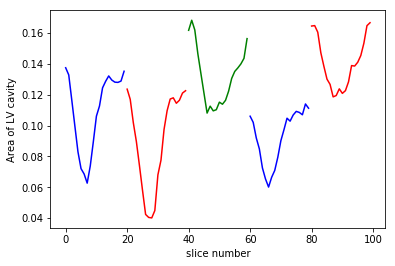

In [6]:
S = 20
k = 5
A = 0
for i in range(k):
    print(data['lv_phase'][0,i*S:(i+1)*S])
    
plt.plot(data['areas'][A,:S], 'b', range(S, 2*S), data['areas'][A,S:S+S], 'r',
        range(2*S, 3*S), data['areas'][A,2*S:3*S], 'g', 
        range(3*S, 4*S), data['areas'][A,3*S:4*S], 'b',
        range(4*S, 5*S), data['areas'][A,4*S:5*S], 'r')
plt.xlabel('slice number')
plt.ylabel('Area of LV cavity')

**Remark:**

It appears from the plot above that when the LV cavity area decreases, the phase is 1: Systole.

And, it equals 0 (diastole) when LV cavity increases. So one way to find the phase is to track
the LV cavity area

In [7]:
patient = data['images_LV'][:,:,:20]
seg_endo = data['endo_LV'][:,:,:20]
seg_epi = data['epi_LV'][:,:,:20]

def get_sample(seq, size=3):
    return np.hstack([seq[:,:,i] for i in range(size)])

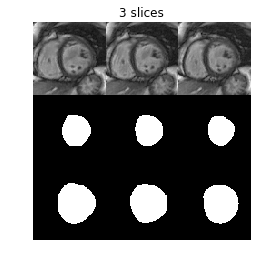

In [8]:
n = 3
slice_sample = get_sample(patient, n)
seg_endo_sample = get_sample(seg_endo, n)
seg_epi_sample = get_sample(seg_epi, n)
samples = np.vstack((slice_sample, seg_endo_sample, seg_epi_sample))
plt.imshow(samples, cmap='gray')
plt.title(f'{n} slices')
plt.axis("off")
plt.show()


In [9]:
print ('dims attribute', data['dims'].shape, data['dims'][:,0])
print ('areas attribute', data['areas'].shape, data['areas'][:,0])
print ('rwt attribute', data['rwt'].shape, data['rwt'][:,0])

dims attribute (3, 2900) [ 0.40795  0.4411   0.40617]
areas attribute (2, 2900) [ 0.13742  0.09059]
rwt attribute (6, 2900) [ 0.06005  0.04753  0.05253  0.05125  0.04902  0.06165]


# Our approach

We're going to directly predict LV indices from images without segmentation.

For that we use a classical model (e.g resnet50) for a regression task where the output
vector will contain all these values:
1. Areas: 2 values
2. Dimensions: 3 values
3. Reginal Wall Thickness: 6 values

Thus, an output vector of 11 values.

For the cardiac phase, we plan to use direct algorithm, no machine learning,
that will track LV area (A1) across slices and use the remark done above
to find the cardiac phase.


In [10]:
def show_min_max(feats, name):
    print(f'min')
    
min_max = {}
for k in ['areas', 'dims', 'rwt']:
    l = data[k].shape[0]
    for i in range(l):
        min_max[k+'_'+str(i+1)] = [np.min(data[k][i,:]), np.max(data[k][i,:]), np.mean(data[k][i,:])]

In [11]:
df = pd.DataFrame(min_max).transpose()
print(df)
df.to_csv("LV_indices_sumup.csv",  header=[ 'min', 'max', 'mean'])

                0         1         2
areas_1  0.028125  0.206016  0.122527
areas_2  0.049023  0.245039  0.115107
dims_1   0.188220  0.509289  0.377495
dims_2   0.195758  0.540953  0.402957
dims_3   0.173934  0.556315  0.392373
rwt_1    0.021334  0.198047  0.085638
rwt_2    0.010757  0.170242  0.065623
rwt_3    0.016626  0.173010  0.064851
rwt_4    0.019094  0.167630  0.066266
rwt_5    0.018727  0.179142  0.064009
rwt_6    0.024604  0.209354  0.080259


In [12]:
infos = pd.read_csv('LV_indices_sumup.csv', )
infos

,Unnamed: 0,min,max,mean
0,areas_1,0.028125,0.206016,0.122527
1,areas_2,0.049023,0.245039,0.115107
2,dims_1,0.188220,0.509289,0.377495
3,dims_2,0.195758,0.540953,0.402957
4,dims_3,0.173934,0.556315,0.392373
5,rwt_1,0.021334,0.198047,0.085638
6,rwt_2,0.010757,0.170242,0.065623
7,rwt_3,0.016626,0.173010,0.064851
8,rwt_4,0.019094,0.167630,0.066266
9,rwt_5,0.018727,0.179142,0.064009


In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
# torch.cuda.set_device(3)

### Format input/output for CNN

Make one-channel input to 3 channel.
Arrange input/output axis for fastai.

(2900, 11)
(2900, 80, 80, 3)


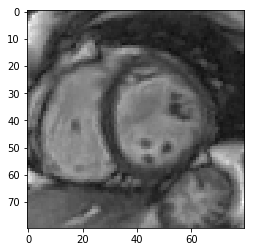

In [4]:
tmp_x = np.moveaxis(data['images_LV'], -1, 0)
x = np.empty((2900, 80, 80, 3))
for i in range(x.shape[0]):
    x[i] = np.stack((tmp_x[i],)*3, -1)

y = np.concatenate((data['areas'],data['dims'], data['rwt'])).T
print(y.shape)
print(x.shape)
plt.imshow(x[0])

In [5]:
# trn, val, test
val = get_cv_idxs(115, val_pct=0.28)
trn = np.array(list(set(range(115)) - set(val)))
test = np.arange(115, 145)
dtrn = (x[trn], y[trn])
dval = (x[val], y[val])
dtest = (x[test], y[test])
darray = (dtrn, dval, dtest)

In [6]:
def get_data(darray, arch, bs, aug=transforms_top_down):
    tfms = tfms_from_model(arch, sz=80, aug_tfms=aug, crop_type=CropType.NO)
    trn, val, test = darray
    data = ImageClassifierData.from_arrays(PATH, trn, val, bs, tfms, test=test, continuous=True)
    return data

arch = resnext50
bs=8
md = get_data(darray, arch, bs, aug=transforms_top_down)
md.is_reg()

True

In [7]:
head_reg11 = nn.Sequential(Flatten(), nn.Linear(18432,11))
# head_reg11 = nn.Sequential(Flatten())
learner = ConvLearner.pretrained(arch, md, custom_head=head_reg11)
learner.opt_fn = optim.Adam
learner.crit = nn.L1Loss()

In [52]:
learner.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 80, 80]),
                           ('output_shape', [-1, 64, 40, 40]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 40, 40]),
                           ('output_shape', [-1, 64, 40, 40]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 40, 40]),
                           ('output_shape', [-1, 64, 40, 40]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 40, 40]),
                           ('output_shape', [-1, 64, 20, 20]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 20, 20]),
        

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      687.854067 19386.631836



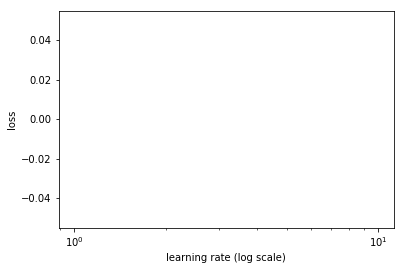

In [8]:
learner.lr_find(1e-5,100)
learner.sched.plot(5)

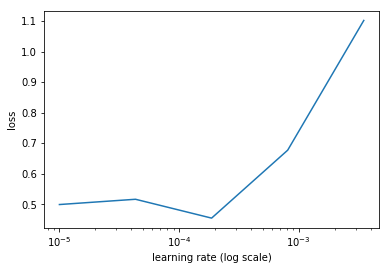

In [10]:
learner.sched.plot(0)

In [12]:
lrf = 1e-4
lrf

0.0001

In [14]:
learner.fit(lrf, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                             
    0      0.495669   0.468196  
    1      0.458215   0.512415                             
    2      0.401324   0.302271                            



[array([ 0.30227])]

In [16]:
lrs = np.array([lrf/100,lrf/10,lrf])
learner.freeze_to(-2)
learner.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                             
    0      0.306097   0.316369  
    1      0.3002     0.356218                            
    2      0.288668   0.322271                            



[array([ 0.32227])]

In [18]:
learner.freeze_to(-3)
learner.fit(lrs, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                             
    0      0.279953   0.357601  
    1      0.294477   0.357749                             
    2      0.284334   0.317256                             



[array([ 0.31726])]

In [19]:
learner.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss                             
    0      0.292157   0.325671  
    1      0.284726   0.358654                             
    2      0.27469    0.315133                             
    3      0.27442    0.302813                             
    4      0.271334   0.297785                             
    5      0.262186   0.299573                             
    6      0.25861    0.288051                             



[array([ 0.28805])]

In [24]:
learner.fit(lrs, 10, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1023), HTML(value='')))

epoch      trn_loss   val_loss                             
    0      0.238666   0.218117  
    1      0.241194   0.248962                             
    2      0.22946    0.219057                             
    3      0.236058   0.258885                             
    4      0.232595   0.241522                             
    5      0.227192   0.212714                             
    6      0.222231   0.213214                             
    7      0.22144    0.225825                             
    8      0.218501   0.255444                             
    9      0.221256   0.26027                              
    10     0.223437   0.238534                             
    11     0.222449   0.230085                             
    12     0.218      0.210831                             
    13     0.215281   0.199879                             
    14     0.210269   0.202548                             
    15     0.209583   0.230694                             
    16 

   136     0.202845   0.290753                             
   137     0.206833   0.244435                             
   138     0.209315   0.232332                             
   139     0.209879   0.302143                             
   140     0.215815   0.276756                             
   141     0.222494   0.246881                             
   142     0.223974   0.262178                             
   143     0.222865   0.227465                             
   144     0.221344   0.241285                             
   145     0.218952   0.232798                             
   146     0.214994   0.248621                             
   147     0.2158     0.261502                             
   148     0.214934   0.248198                             
   149     0.21281    0.249785                             
   150     0.212339   0.265274                             
   151     0.212447   0.246888                             
   152     0.214074   0.276035          

   272     0.199044   0.26086                              
   273     0.198684   0.269232                             
   274     0.198032   0.239959                             
   275     0.20036    0.270333                            
   276     0.202515   0.230958                             
   277     0.199686   0.227679                            
   278     0.198606   0.235414                             
   279     0.197241   0.250299                             
   280     0.195705   0.268609                             
   281     0.197045   0.236034                             
   282     0.198828   0.260666                             
   283     0.199033   0.248686                             
   284     0.200199   0.232325                             
   285     0.198596   0.236692                             
   286     0.197947   0.20814                              
   287     0.197145   0.239676                             
   288     0.196283   0.210193            

   408     0.111352   0.086797                             
   409     0.112319   0.087791                             
   410     0.110751   0.083385                             
   411     0.109523   0.095484                             
   412     0.108206   0.093314                             
   413     0.10772    0.0938                               
   414     0.106254   0.097497                             
   415     0.106961   0.093381                             
   416     0.107697   0.090733                             
   417     0.108953   0.101953                             
   418     0.108755   0.1012                               
   419     0.107834   0.099196                             
   420     0.108726   0.092392                             
   421     0.106812   0.086066                             
   422     0.106796   0.081022                             
   423     0.105485   0.092624                             
   424     0.103541   0.08862           

KeyboardInterrupt: 

In [23]:
learner.predict(is_test=True)

array([[ 0.43752,  0.19376,  0.23028,  0.48783,  0.65563,  0.14477,  0.15997,  0.08975,  0.31381,  0.40025,
         0.4398 ],
       [ 0.19854,  0.16553,  0.05075,  0.1606 ,  0.71916,  0.3611 , -0.10735,  0.29213,  0.42696,  0.75695,
         0.06322],
       [ 0.34907, -0.02793,  0.33441,  0.48544,  0.39349,  0.15136,  0.49814,  0.1995 ,  0.2599 ,  0.37203,
         0.04786],
       [ 0.63552,  0.06662,  0.67939,  0.31441,  0.68474,  0.06812,  0.18396, -0.00956,  0.36853,  0.02374,
        -0.11204],
       [ 0.58442,  0.41424,  0.02572,  0.19768,  0.3376 ,  0.03581,  0.14403, -0.00424,  0.28253,  0.17136,
         0.14121],
       [ 0.13596, -0.34933,  1.0354 ,  0.42856,  0.2193 ,  0.03777, -0.01646, -0.35882, -0.01946,  0.37502,
        -0.3083 ],
       [-0.17909, -0.37956,  0.91832,  0.33248,  0.44259,  0.08977,  0.36954, -0.09531, -0.12372,  0.06588,
        -0.13676],
       [ 0.02537,  0.27316,  0.92486,  0.79218,  0.40847,  0.52149,  0.491  ,  0.00713,  0.46746,  0.08405,
   

## Visualization of endocardium and epicardium

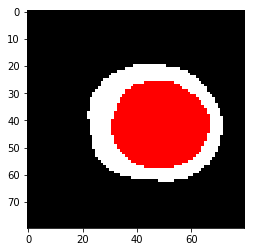

In [167]:
red  = (255, 0, 0) #np.array([255, 0, 0], dtype=np.uint8)
green = (0, 255, 0) #np.array([0, 255, 0], dtype=np.uint8)
blue   = (0, 0, 255) 
def overlay(im, mask, color):
    overlaid = im.copy()
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if (mask[i,j] > 100).all():
                overlaid[i,j] = color
    return overlaid

pat_endo = data['endo_LV'][:,:,200]
pat_endo = make_cv2_compatible(pat_endo)
pat_epi = data['epi_LV'][:,:,200]
pat_epi = make_cv2_compatible(pat_epi)
both = overlay(pat_epi, pat_endo, red)
plt.imshow(both)



## Compute Bounding Boxes of endocardium and epicardium segments

(80, 80, 3)
1
(22, 20, 50, 43)


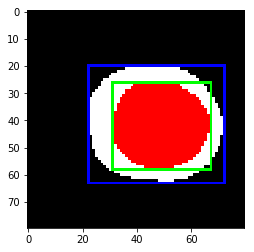

In [169]:
import cv2

def make_cv2_compatible(img, cmap='gray'):
    plt.imsave("tmp.jpg", img, cmap=cmap )
    im = cv2.imread('tmp.jpg')
    return im

def min_max(x):
    return np.min(x), np.max(x)


def meth1(pat):
    xs, ys = np.where(pat==1)
    min_x, max_x = min_max(xs)
    min_y, max_y = min_max(ys)
    # points = [[xs[i], ys[i]] for i in [min_x, max_x, min_y, max_y]]
    points = np.array([[min_y,min_x], [max_y,max_x]])
    return  cv2.boundingRect(points)
 
def get_bb(pat):
    im = make_cv2_compatible(pat)
    ctrs= cv2.findContours( cv2.cvtColor(im, cv2.COLOR_BGR2GRAY),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE )[1]
    return cv2.boundingRect(ctrs[0])
    
pat = data['epi_LV'][:,:,200]




xs, ys = np.where(pat==1)

min_x, max_x = min_max(xs)
min_y, max_y = min_max(ys)
# points = [[xs[i], ys[i]] for i in [min_x, max_x, min_y, max_y]]
points = np.array([[min_y,min_x], [max_y,max_x]])
# seg_endo[:,:,0][22,39]
pat = make_cv2_compatible(pat)
print(pat.shape)
ctrs= cv2.findContours( cv2.cvtColor(pat, cv2.COLOR_BGR2GRAY),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE )[1]
print(len(ctrs))
(x, y, w, h) = cv2.boundingRect(points)
print((x, y, w, h))
cv2.rectangle(both,(x, y), (x + w, y + h), (0, 0, 255), 1)
plt.imshow(both)

In [158]:
n = data["images_LV"].shape[-1]
print(data['endo_LV'].shape,n)
endo_bb = [meth1(data['endo_LV'][:,:,i]) for i in range(n)]
epi_bb = [meth1(data['epi_LV'][:,:,i]) for i in range(n)]

(80, 80, 2900) 2900
